# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector.file_discovery import find_files, find_folders
from resurfemg.pipelines.ipy_widgets import file_select
from resurfemg.data_connector.adicht_reader import AdichtReader
from resurfemg.data_connector.data_classes import EmgDataGroup, VentilatorDataGroup

config = Config(verbose=True)

%matplotlib widget

Loaded config from:
 C:\Users\WarnaarRSP/.resurfemg/config.json

The following paths were configured:
-------------------------------------------------------------------------------
 Name           	Path                                              
-------------------------------------------------------------------------------
 root           	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addict\not_pushed
 output_data    	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addicht\not_pushed\output_data
 patient_data   	P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW
 resurfemg_root 	P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie  
 preprocessed_data	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addicht\not_pushed\preprocessed_data
 simulated_data 	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addicht\not_pushed\simulated_data
 test_data      	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addict\test_data


## 2. Load sEMG test data

In [2]:
# File selection
base_path = config.get_directory('test_data')

files = find_files(
    base_path=base_path,
    file_name_regex='*',
    extension_regex='adi*',
    folder_levels=None,
    verbose=False
)

button_list = file_select(
    files=files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('all_data_synth_quiet_breathing.adidat', 'emg_da…

In [3]:
# Load the EMG from the selected folders:
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in button_list])
adicht_data = AdichtReader(emg_file_chosen)

# Print metadata
_ = adicht_data.print_metadata()    
# NB: The third channel is in the example data
# (all_data_synth_quiet_breathing.adidat) is empty, so we will not be used

Available channels and metadata:
+------------+-----------+---------+---------+--------------------+---------------+--------+
| Channel ID | Name      | Records | Samples | Sampling Rate (Hz) |  timestep (s) | Units  |
+------------+-----------+---------+---------+--------------------+---------------+--------+
|     1      | ECG       |    1    |  860160 |       2048.0       | 0.00048828125 | ['mV'] |
|     2      | EMGdi     |    1    |  860160 |       2048.0       | 0.00048828125 | ['mV'] |
|     3      | Channel 3 |    1    |    0    |       2048.0       | 0.00048828125 |  ['']  |
|     4      | P         |    1    |  42000  |       100.0        |      0.01     | ['mV'] |
|     5      | F         |    1    |  42000  |       100.0        |      0.01     | ['mV'] |
|     6      | V         |    1    |  42000  |       100.0        |      0.01     | ['mV'] |
+------------+-----------+---------+---------+--------------------+---------------+--------+


In [4]:
# Extract the EMG data
select_channel_idxs = [0, 1]
record_idx = 0
resample_channels_dict = None

data_emg_df, fs_emg = adicht_data.extract_data(
    channel_idxs=select_channel_idxs,
    record_idx=record_idx,
    resample_channels=resample_channels_dict,
)
# Get the labels and units of the selected channels
y_emg = data_emg_df.to_numpy().T
labels  = adicht_data.get_labels(select_channel_idxs)
units   = adicht_data.get_units(select_channel_idxs, record_idx)
# NB: The units in the example data are in mV, so overwrite them to uV
units = ['uV' for _ in units]

# Store the EMG data in a group of TimeSeries objects
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=labels,
    units=units)

Auto-detected ECG channel from labels.


In [5]:
emg_timeseries.set_ecg_idx(0)

In [6]:
# Extract the ventilator data
select_channel_idxs = [3, 4, 5]
record_idx = 0
resample_channels_dict = None

data_vent_df, fs_vent = adicht_data.extract_data(
    channel_idxs=select_channel_idxs,
    record_idx=record_idx,
    resample_channels=resample_channels_dict,
)
# Get the labels and units of the selected channels
y_vent = data_vent_df.to_numpy().T
labels  = adicht_data.get_labels(select_channel_idxs)
units   = adicht_data.get_units(select_channel_idxs, record_idx)
# NB: The units in the example data are in mV, so overwrite them:
units = ['cmH2O', 'L/min', 'mL']

# Store the ventilator data in a group of TimeSeries objects
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=labels,
    units=units)

Auto-detected Flow channel from labels.


In [7]:
# Alternatively, the data can be resampled

# Select the channels and records to be extracted by index (default)
select_channel_idxs = [0, 1, 3, 4, 5]
record_idx = 0

# Set the resampling rate for each channel
resample_channels_dict={       
  3: 2048,
  4: 2048,
  5: 2048,
}

# Extract the data
data_all_df, fs_all = adicht_data.extract_data(
    channel_idxs=select_channel_idxs,
    record_idx=record_idx,
    resample_channels=resample_channels_dict,
)

# Get the labels and units of the selected channels
y_all = data_emg_df.to_numpy().T
labels  = adicht_data.get_labels(select_channel_idxs)
units   = adicht_data.get_units(select_channel_idxs, record_idx)

1 [0.01]


IndexError: list index out of range

In [8]:
# adicht_data.adicht_data.channels[0].dt[0]
adicht_data.record_map

{0: 1}

In [6]:
emg_timeseries.set_ecg_idx(0)

# 3. Pre-process the data

In [13]:
# Filter
emg_timeseries.run('filter_emg')

In [14]:
# # Through gating
# emg_timeseries.gating(overwrite=True)
emg_timeseries.run('gating', overwrite=True)

# # Through wavelet denoising
# emg_timeseries.run('wavelet_denoising', overwrite=True)
# # emg_timeseries.run('wavelet_denoising', n=8, fixed_threshold=8.0, overwrite=True)

Set ECG channel used for ECG removal.


In [15]:
# Calculate the envelope of the signal
emg_timeseries.run('envelope')
# emg_timeseries.run('envelope', ci_alpha=0.05)
# emg_timeseries.run('envelope', env_type='arv')
# emg_timeseries.run('envelope', env_type='arv', ci_alpha=0.05)

In [16]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.run('baseline')
# vent_timeseries.run(
#     'baseline',
#     channel_idxs=[0],
#     signal_type='raw')

(0.0, 10.0)

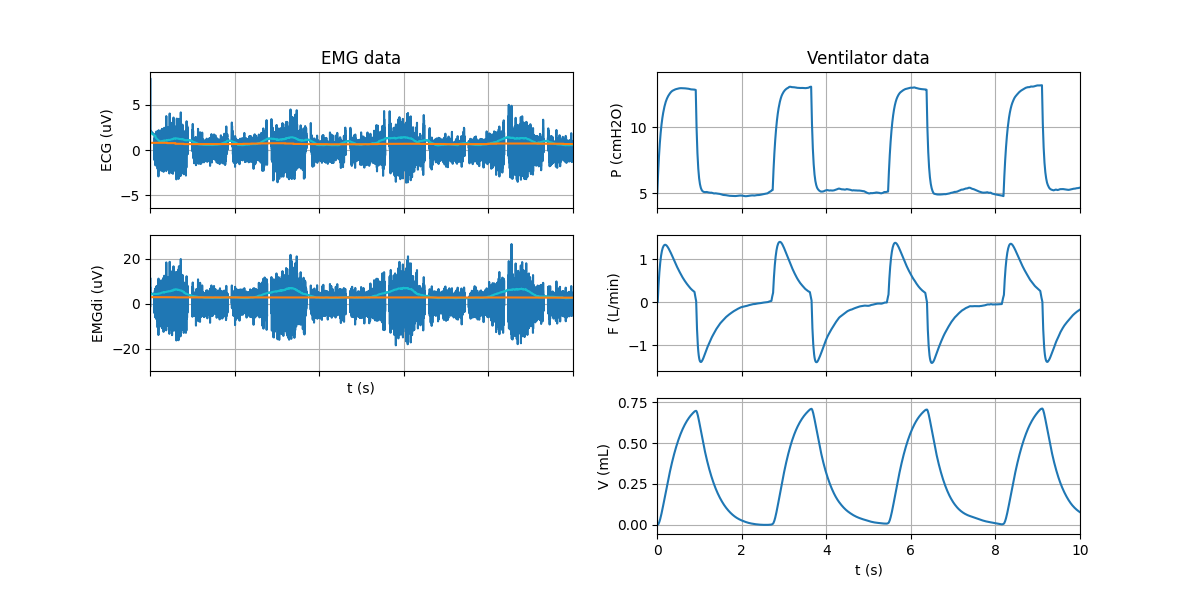

In [17]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axes_emg = axis[:2, 0]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_type='clean', baseline_bool=False)
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# Ventilator data data
axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

axis[-1, 0].axis('off')

axes_vent[-1].set_xlim([0, 10])